In [16]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob
import matplotlib.pyplot as plt
import tensorflow as tf

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
#TODO: Tester classification binaire (Photo ou pas), multi classe (Photo, Painture) et multi label (Photo 80%, Peinture 2%)

In [3]:
now = datetime.datetime.now().strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()
data_path = f"{project_path}/data"
train_data_path = f"{data_path}/train"
validation_data_path = f"{data_path}/validation"
model_path = f"{project_path}/models"
checkpoint_path = f"{project_path}/weights/model_early/"
log_path = f"{project_path}/logs/fit/{now}_model"

os.makedirs(data_path, exist_ok=True)
os.makedirs(train_data_path, exist_ok=True)
os.makedirs(validation_data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(checkpoint_path, exist_ok=True)
os.makedirs(log_path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 32

In [6]:
def download_dataset(force=False):
    
    dataset_path = f'{train_data_path}/dataset.zip'

    if os.path.exists(dataset_path) and force == False:
        print("Dataset already downloded")
    else:
        print("Downloading dataset")
        url = 'https://drive.google.com/uc?export=download&id=1vhNmk5omNcX3g9enqETvFR_2vdVONsxo'
        gdown.download(url, dataset_path, quiet=False)
    
    if len(os.listdir(train_data_path)) == 6 and force == False:
        print("Dataset already exported")
    else:
        print("Exporting dataset")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Décompression", unit="fichier") as pbar:
                    for file in files:
                        zip_ref.extract(file, train_data_path)
                        pbar.update(1)
            zip_ref.extractall(train_data_path)
            print(f"Dataset downloaded {train_data_path}")
        
download_dataset()

Dataset already downloded
Exporting dataset


Décompression: 100%|██████████| 32762/32762 [01:19<00:00, 413.12fichier/s]


Dataset downloaded C:\Users\lefra\Documents\Projets\ProjetDeepLearning\livrable_1/data/train


In [18]:
def check_images_in_dataset(dataset_path):
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)
            
        except tf.errors.InvalidArgumentError as e:
            print(f"Found bad file: {img_path}. Removing it.")
            os.remove(img_path)

check_images_in_dataset(train_data_path)

Checking images:  61%|██████    | 20010/32756 [03:15<01:40, 126.20it/s]

Found bad file: C:\Users\lefra\Documents\Projets\ProjetDeepLearning\livrable_1/data/train\schematics\desktop.ini. Removing it.


Checking images: 100%|██████████| 32756/32756 [04:43<00:00, 115.38it/s]


In [7]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels="inferred",
    label_mode="int"
)

Found 32756 files belonging to 2 classes.
Using 26205 files for training.
Using 6551 files for validation.


In [8]:
class_names = test_set.class_names
class_num = len(class_names)
print(class_names)

['train', 'validation']


In [9]:
def preprocess_image(image, label):
    # Redimensionne l'image en conservant le ratio d'aspect (padding si nécessaire)
    image = tf.image.resize_with_pad(image, image_h, image_w)
    return image, label

train_set = train_set.map(preprocess_image)
test_set = test_set.map(preprocess_image)

Image shape:  (32, 224, 224, 3)
Labels shape:  (32,)


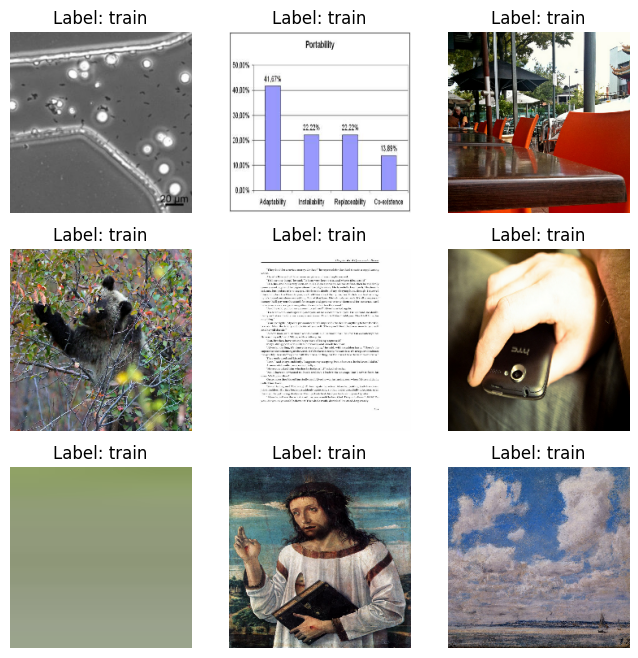

In [10]:
def print_img(dataset, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()
        
images, labels = iter(train_set).next()
print("Image shape: ", images.shape)
print("Labels shape: ", labels.shape)
print_img(train_set, 9)

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

In [13]:
def create_model(input_shape=(image_h, image_w, 3)):
    model = tf.keras.models.Sequential()
    
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
    )
    
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))
    
    model.add(data_augmentation)
        
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(class_num, activation='softmax'))
    
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer="adam", loss=loss_function, metrics=['accuracy'])
    
    model.summary()
    
    return model

model = create_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,498 (24.59 MB)

 Trainable params: 6,446,498 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
def get_callbacks():    
    # Create a callback that saves the model's weights
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path + "/weights-epoch-{epoch:02d}-{val_loss:.2f}.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )
    
    # Tensorboard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_path,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0
    )
    
    # Early stopping
    early_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )

    return [checkpoint_callback, tensorboard_callback, early_callback]

In [15]:
epochs = 10
history = model.fit(
    train_set,
    epochs=epochs, 
    validation_data=test_set,
    callbacks=get_callbacks()
)
model.save(f"{model_path}/model.keras")

Epoch 1/10


KeyboardInterrupt: 

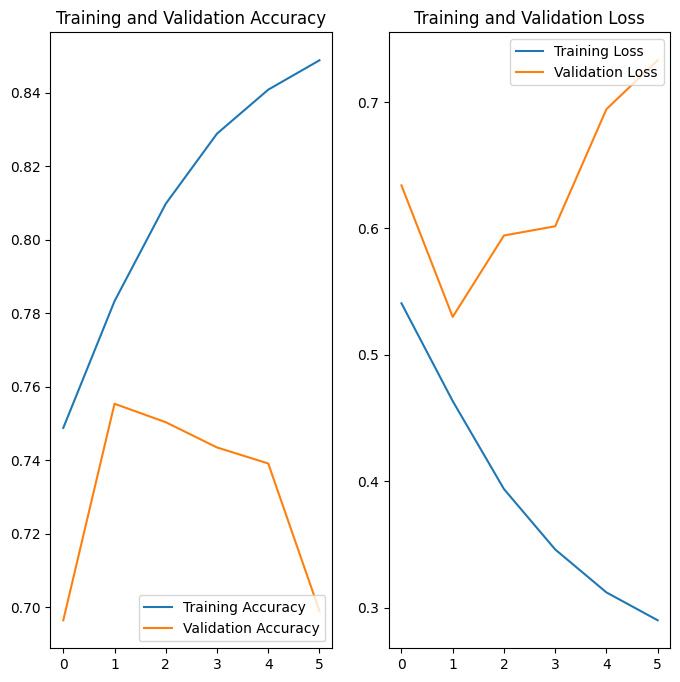

In [39]:
# Récupération des métriques d'entraînement et de validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la plage d'époques
epochs_range = range(len(acc))

# Création de la figure
plt.figure(figsize=(8, 8))

# Graphique de précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Graphique de perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Affichage
plt.show()